In [33]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
import os
import glob
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [40]:
"""
Helper functions.
"""

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def pad(arr,windowSize):
    
    """
    Pads array to be divisible by window size.
    """
    
    divisible = False
    while divisible == False:
        if  arr.shape[0] % windowSize != 0:
            arr = np.pad(arr,((0,2),(0,0)),"constant")
        if  arr.shape[1] % windowSize != 0:
            arr = np.pad(arr,((0,0),(0,2)),"constant")

        if all([dim % windowSize ==0 for dim in arr.shape])==True:
                divisible = True
    return arr

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0] -1 
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0] -1 
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block>=196).astype("float64")/block.size # Calculates percentage of array = 255.

def removeFiles(path):
    """
    Remove all files in a path.
    """
    files = glob.glob(path+"*")
    for f in files:
        os.remove(f)
        
    
#Remove black
def removeBlack(img,blackThresh):
    img
    black = np.logical_and.reduce((img[:,:,0] > blackThresh,
                                   img[:,:,1] > blackThresh,
                                   img[:,:,2] > blackThresh, 
                                   img[:,:,3] > blackThresh))
    black4 = np.dstack([black for i in range(3)])
    img[np.logical_not(black4)] = mstats.mode(img[:,:,:3],axis=None)[0]

In [41]:
from scipy import ndimage

def getBlobsOld(img,thresh,show=0):
    blobs, numberOfBlobs = ndimage.label(img)
    objs = ndimage.find_objects(blobs)
    significantObjects = []
    for i in range(len(objs)):
        obj = objs[i]
        area = (obj[0].stop - obj[0].start)*(obj[1].stop - obj[1].start)

        if float(area)/img.size > thresh:
            significantObjects.append(obj)
            if show == 1:
                plt.imshow(img[obj])
                plt.show()
    if len(significantObjects)==0:
        return getBlobs(img,thresh-0.01)
    else:
        return significantObjects
    
def getBlobs(img,thresh,show=0):
    
    blobs, numberOfBlobs = ndimage.label(img)
    objs = ndimage.find_objects(blobs,max_label=4)
    significantObjects = []
    for uniqueValue in np.arange(1,np.max(blobs)+1):
        blobs2 = blobs.copy().astype("uint8")
        blobs2[blobs2!=uniqueValue] = 0
        _,thresh1 = cv2.threshold(blobs2,uniqueValue-0.05,1,cv2.THRESH_BINARY)
        try:
            contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            cnt = contours[0]
            x,y,w,h = cv2.boundingRect(cnt)
            sig = blobs2[y:y+h,x:x+w]
            if float(sig.size)/img.size > thresh:
                significantObjects.append(sig)      
        except IndexError:
            pass

    #for i in significantObjects:
    #    plt.imshow(i,cmap=cm.gray)
     #   plt.show()
    if len(significantObjects)==0:
        return getBlobs(img,thresh-0.01)
    else:
        return significantObjects


def templateMatch(img,templateImg,areaThresh,angleInterval,methodStr):
    method = eval(methodStr)
    templates = getBlobs(templateImg,areaThresh,0)
    boxes = []
    img2 = img.copy()
    #plt.imshow(img,cmap=cm.gray)
    #plt.show()
    #plt.imshow(templateImg,cmap=cm.gray)
    #plt.show()
    # For every template in our set of templates
    for temp in templates:

        print("Template %d out of %d"%(templates.index(temp)+1,len(templates)))
        #plt.imshow(templateImg[temp],cmap=cm.gray)
        #plt.show()
        
        bestRotationAngle = 0
        highestMaxVal = 0
        bestCoords = None
        
        # Rotate each template throughout 360 to find best match based on maximum value generated by match template
        for angle in np.arange(0,360,angleInterval):
            
            dst = ndimage.rotate(temp, angle) # dst is new name for rotated template
            
            (wImg,hImg),(wDst,hDst) = img.shape[::-1], dst.shape[::-1]
            if wImg < wDst:
                wDiff = wDst - wImg
                dst = dst[wDiff/2:(wDst-wDiff/2-1)]
                #print("too wide %d < %d" %(wImg,wDst))
                #print(dst.shape)
            if hImg < hDst:
                hDiff = hDst - hImg
                dst = dst[hDiff/2:(hDst-hDiff/2-1)]
                #print("too tall %d < %d" %(hImg,hDst))
                #print(dst.shape)
            
            w, h = dst.shape[::-1]
            
            ##.imshow(dst,cmap=cm.gray)
            #plt.title("Angle of %d" % angle)
            #plt.show()
            
            try:
                # Apply template matching
                res = cv2.matchTemplate(img2,dst,method)
                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                    topLeft = minLoc
                else:
                    topLeft = maxLoc
                bottomRight = (topLeft[0] + w, topLeft[1] + h)
                if maxVal > highestMaxVal:
                    bestCoords = (topLeft,bottomRight,w,h)
                    highestMaxVal = maxVal
                    bestRotationAngle = angle
                    bestRes = res
            except:
                pass
            
            
        #cv2.rectangle(img2,bestCoords[0], bestCoords[1], 255, 20)
        boxes.append({"topLeft":bestCoords[0],"w":bestCoords[2],"h":bestCoords[3]})
        #plt.imshow(bestRes,cmap=cm.gray)
        #plt.show()
        #plt.imshow(img2,cmap=cm.gray)
        #plt.show()
        
    # Make thresholded image
    mask = np.zeros(img2.shape,np.uint8)
    for box in boxes:
        topLeft = box.get("topLeft")
        w = box.get("w")
        h = box.get("h")
        mask[topLeft[1]:topLeft[1]+h,topLeft[0]:topLeft[0]+w] = img2[topLeft[1]:topLeft[1]+h,topLeft[0]:topLeft[0]+w]

    #plt.imshow(mask,cmap=cm.gray)
    #plt.show()
    return mask


In [42]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize,test,method,saveThresh):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        if train == 1:
            path = "data/"  
        else:
            path = "testData/"  

        self.her2 = openslide.open_slide(path+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        self.he = openslide.open_slide(path+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            

        self.level = 7
        self.lowResDims,self.lowResDimsHE = [x.level_dimensions[self.level] for x in [self.her2,self.he]] #3 is arbitrary but works
        self.lowResRGB, self.lowResRGBHE = [np.asarray(x[0].read_region((0,0),
                    self.level,(x[1][0],x[1][1]))).copy() for x in [(self.her2,self.lowResDims),
                                                                                          (self.he,self.lowResDimsHE)]] 
        
        
        self.lowRes, self.lowResHE = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in self.lowResRGB, self.lowResRGBHE]  # Grayscale
        self.mode, self.modeHE = [mstats.mode(img,axis=None)[0] for img in [self.lowRes, self.lowResHE]]
        
        # Thresholded image
        def thresh(img,threshMargin,blurSize):
            img = cv2.GaussianBlur(img,(blurSize,blurSize),0)
            _,thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-threshMargin,255,1)
            #thresh = cv2.GaussianBlur(thresh,(blurSize,blurSize),0)
            return thresh
        
        threshPath = "/home/msmith/her2/deconv/" + path
        newPath = threshPath + "roi_" + str(caseNo) + "/" + str(self.level) + "/"
        self.thresh = cv2.imread(newPath+"HER2Fitted1106.jpg",0)
        self.threshHE = cv2.imread(newPath+"HEFitted1106.jpg",0)
        
        if saveThresh == True:
            threshHE = thresh(self.lowResHE,threshMargin,blurSize)
            #cv2.imwrite(newPath + "yHE.jpg",threshHE)

        
        # Padd lowRes image and thresholded to make factors
        nrows = ncols = upscaleWindowSize/np.power(2,self.level-upscaleLevel)
        
        self.lowRes, self.thresh = [pad(arr,nrows) for arr in (self.lowRes, self.thresh)]
        self.lowResHE, self.threshHE = [pad(arr,nrows) for arr in (self.lowResHE, self.threshHE)]
        
        def releventCoordsGen(lowRes,thresh,nrows,ncols):
            coordsX,coordsY = np.indices((lowRes.shape[0],lowRes.shape[1]))
            blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
            blocksThresh = blockshaped(thresh,nrows,ncols)
            blocksLowRes = blockshaped(lowRes,nrows,ncols)

            releventCoords = [] # ROIs
            percentage255 = lambda block: np.sum(block>=210).astype("float64")/block.size # Calculates percentage of array = 255.
            featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
            for block in featureBlocks:
                releventCoords.append((blocksX[block],blocksY[block]))
            return releventCoords
        
        self.releventCoords = releventCoordsGen(self.lowRes,self.thresh,nrows,ncols)
        self.releventCoordsHE = releventCoordsGen(self.lowResHE,self.threshHE,nrows,ncols)
        

        
    def showHER2(self):
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        ax1.imshow(self.lowResRGB)
        ax2.set_title('Y1')
        ax2.imshow(self.thresh,cmap = cm.gray)
        plt.show()
        
    def showHE(self):
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        ax1.imshow(self.lowResRGBHE)
        ax2.set_title('Y1')
        ax2.imshow(self.threshHE,cmap = cm.gray)
        plt.show()
             
    def regionGen(self,upscaleLevel,colour=False,HE=0): 
        if HE == 1: 
            releventCoords = self.releventCoordsHE
            her = self.he
            imgRGB = self.lowResRGBHE
        else:
            releventCoords = self.releventCoords
            her = self.her2
            imgRGB = self.lowResRGB
            
        for i in range(len(releventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(releventCoords[i],self.level,upscaleLevel)
            if colour==True:
                thickness = 20
            else:
                thickness = 2
            cv2.rectangle(imgRGB, (x1, y1), (x2, y2), (255,0,0), thickness)
            region = np.asarray(her.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
        


In [46]:
# Hyperparams
numberOfRegions = []
imagesWithLines = [84,82,35]

train = True
threshArea = 0.1
threshMargin = 10
save = 1
show = 1
displayProb = 0.0
blackThresh = 120
#blurSize = 27
upscaleLevels = [5,4,3,2,1]
upscaleLevel = 5
upscaleWindowSize = np.power(2,12-upscaleLevel)


if train == True:
    groundTruth = pd.read_csv("data/groundTruth.csv")
    writePath = "/home/msmith/her2/data/"
else:
    groundTruth = pd.read_csv("testData/groundTruth.csv")
    writePath = "/home/msmith/her2/testData/"

cols = {1: "CaseNo", 2: "HeR2 SCORE",
       3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

method = methods[1]



Upscale level 5
Image 1 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_1/5/HER2/
/home/msmith/her2/data/roi_1/5/HE/


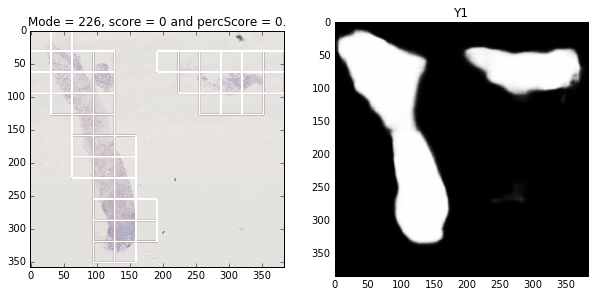

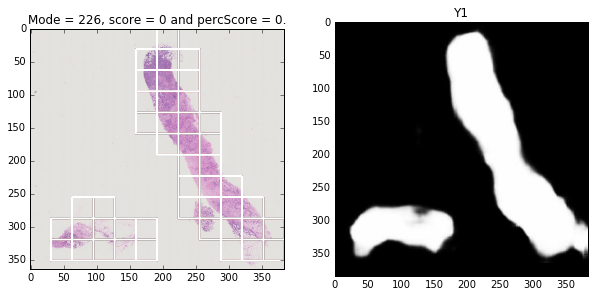

Number of regions generated at level 7 = 90 with dimension 128 x 128 x 3.
Image 4 with score of 2, percScore of 60. Region sizes generated 128.
/home/msmith/her2/data/roi_4/5/HER2/
/home/msmith/her2/data/roi_4/5/HE/


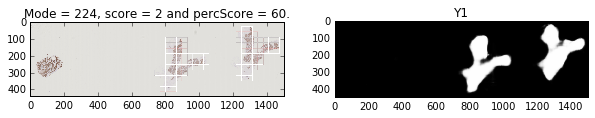

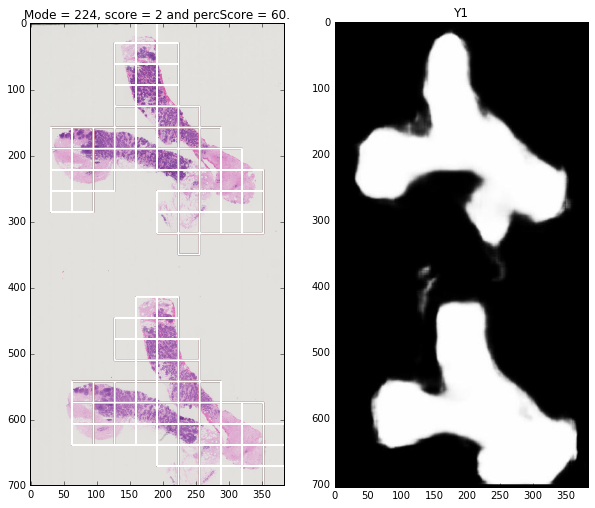

Number of regions generated at level 7 = 195 with dimension 128 x 128 x 3.
Image 6 with score of 2, percScore of 40. Region sizes generated 128.
/home/msmith/her2/data/roi_6/5/HER2/
/home/msmith/her2/data/roi_6/5/HE/


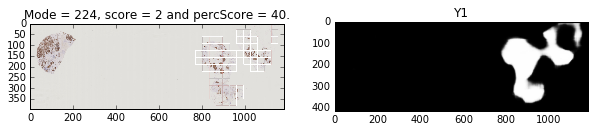

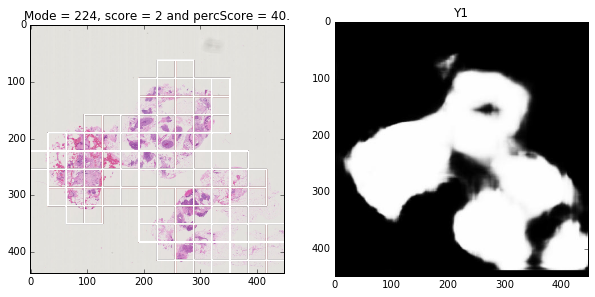

Number of regions generated at level 7 = 153 with dimension 128 x 128 x 3.
Image 9 with score of 3, percScore of 70. Region sizes generated 128.
/home/msmith/her2/data/roi_9/5/HER2/
/home/msmith/her2/data/roi_9/5/HE/


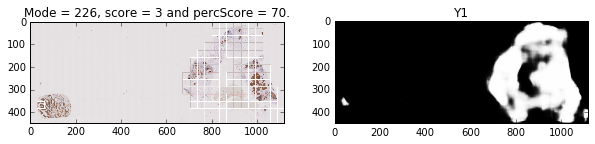

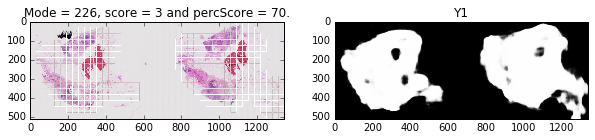

Number of regions generated at level 7 = 467 with dimension 128 x 128 x 3.
Image 11 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_11/5/HER2/
/home/msmith/her2/data/roi_11/5/HE/


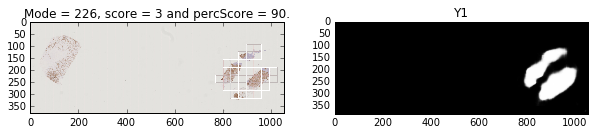

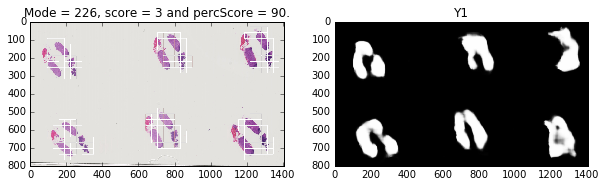

Number of regions generated at level 7 = 215 with dimension 128 x 128 x 3.
Image 12 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_12/5/HER2/
/home/msmith/her2/data/roi_12/5/HE/


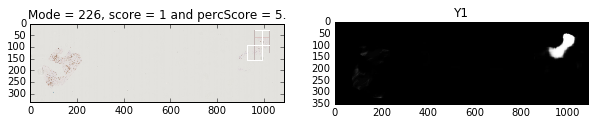

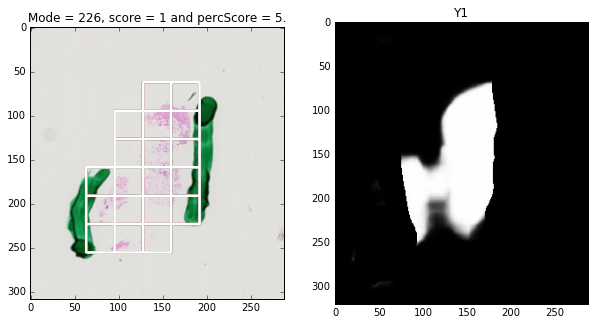

Number of regions generated at level 7 = 28 with dimension 128 x 128 x 3.
Image 13 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_13/5/HER2/
/home/msmith/her2/data/roi_13/5/HE/


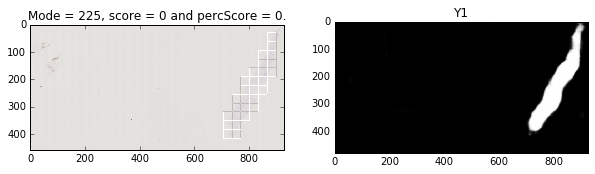

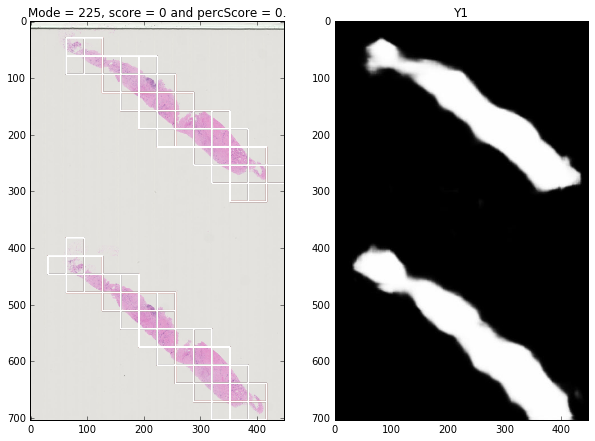

Number of regions generated at level 7 = 97 with dimension 128 x 128 x 3.
Image 14 with score of 1, percScore of 1. Region sizes generated 128.
/home/msmith/her2/data/roi_14/5/HER2/
/home/msmith/her2/data/roi_14/5/HE/


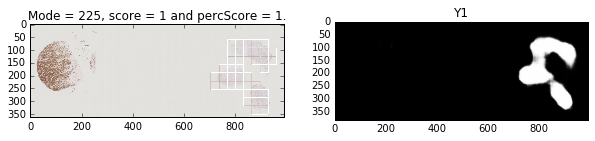

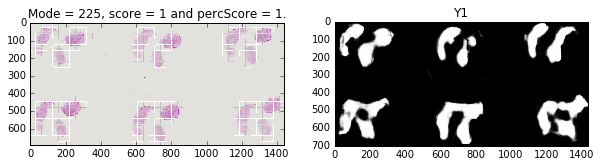

Number of regions generated at level 7 = 268 with dimension 128 x 128 x 3.
Image 15 with score of 1, percScore of 2. Region sizes generated 128.
/home/msmith/her2/data/roi_15/5/HER2/
/home/msmith/her2/data/roi_15/5/HE/


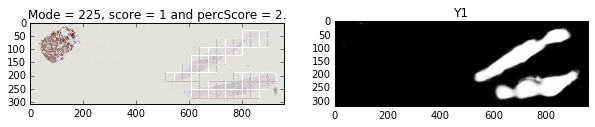

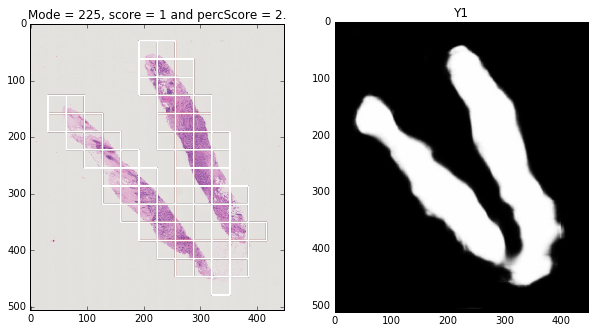

Number of regions generated at level 7 = 116 with dimension 128 x 128 x 3.
Image 16 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_16/5/HER2/
/home/msmith/her2/data/roi_16/5/HE/


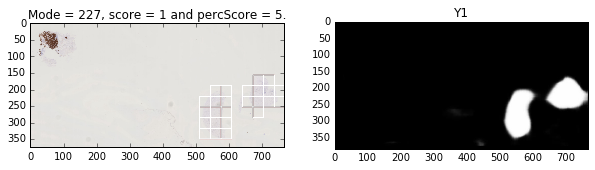

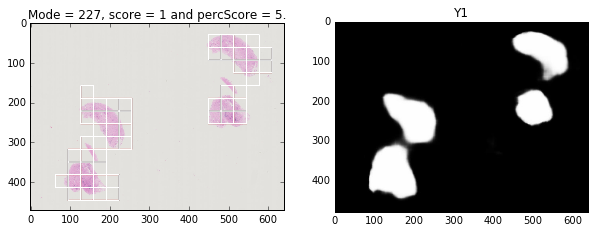

Number of regions generated at level 7 = 77 with dimension 128 x 128 x 3.
Image 18 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_18/5/HER2/
/home/msmith/her2/data/roi_18/5/HE/


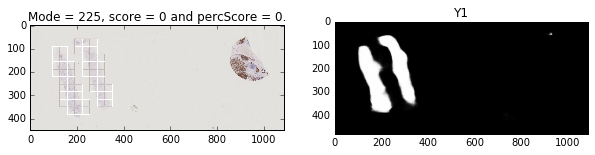

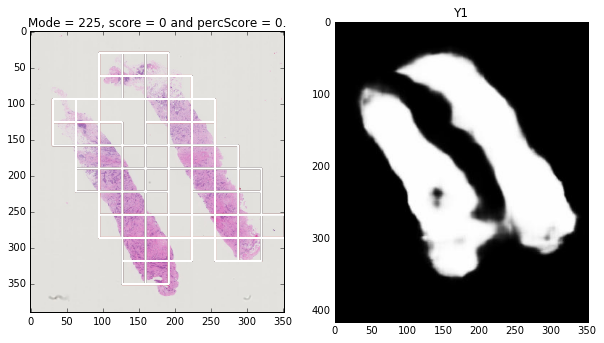

Number of regions generated at level 7 = 101 with dimension 128 x 128 x 3.
Image 19 with score of 3, percScore of 30. Region sizes generated 128.
/home/msmith/her2/data/roi_19/5/HER2/
/home/msmith/her2/data/roi_19/5/HE/


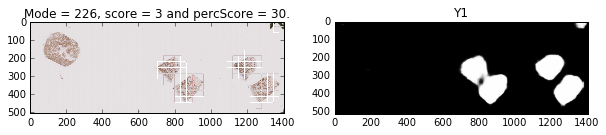

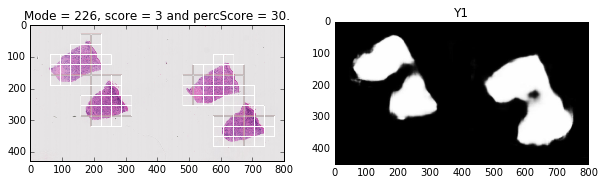

Number of regions generated at level 7 = 172 with dimension 128 x 128 x 3.
Image 22 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_22/5/HER2/
/home/msmith/her2/data/roi_22/5/HE/


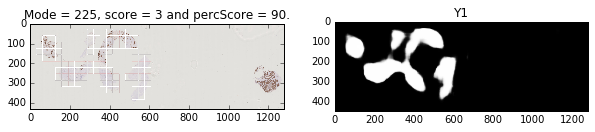

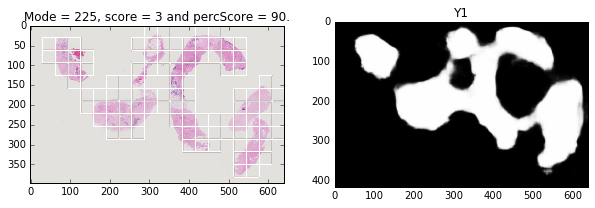

Number of regions generated at level 7 = 196 with dimension 128 x 128 x 3.
Image 24 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_24/5/HER2/
/home/msmith/her2/data/roi_24/5/HE/


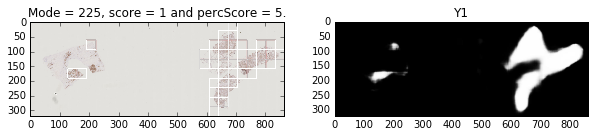

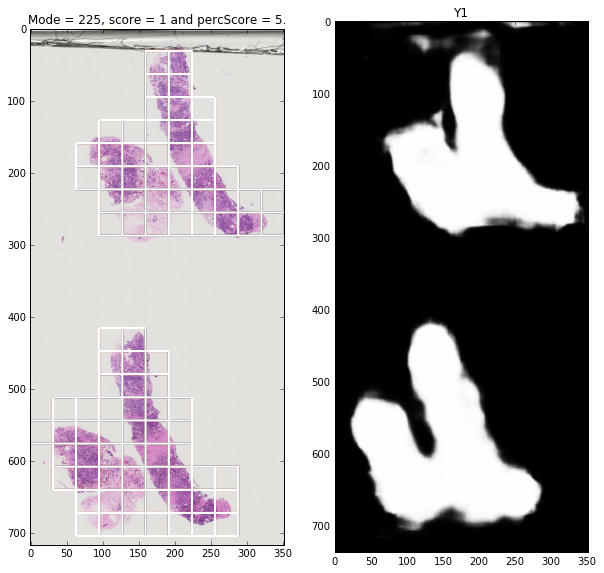

Number of regions generated at level 7 = 131 with dimension 128 x 128 x 3.
Image 25 with score of 2, percScore of 30. Region sizes generated 128.
/home/msmith/her2/data/roi_25/5/HER2/
/home/msmith/her2/data/roi_25/5/HE/


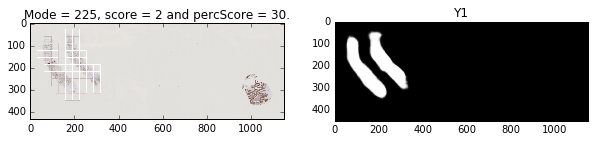

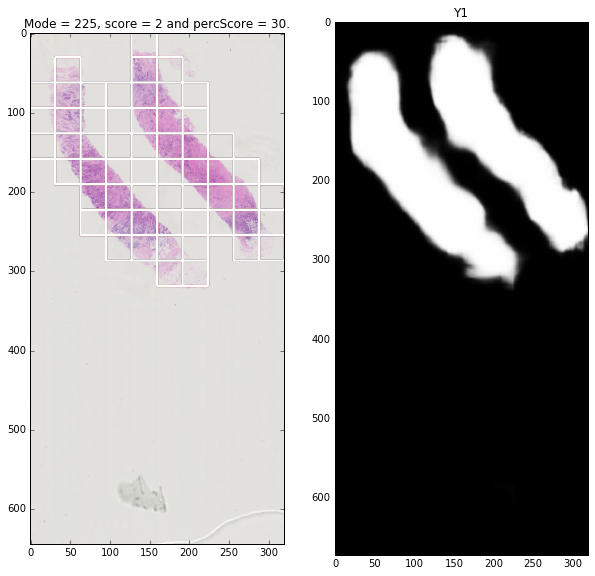

Number of regions generated at level 7 = 101 with dimension 128 x 128 x 3.
Image 26 with score of 2, percScore of 50. Region sizes generated 128.
/home/msmith/her2/data/roi_26/5/HER2/
/home/msmith/her2/data/roi_26/5/HE/


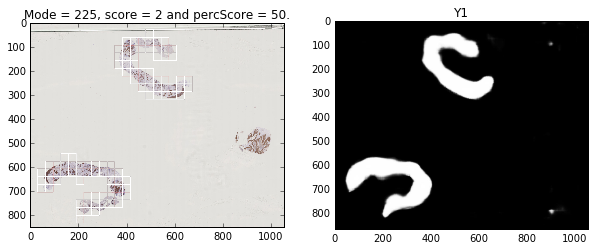

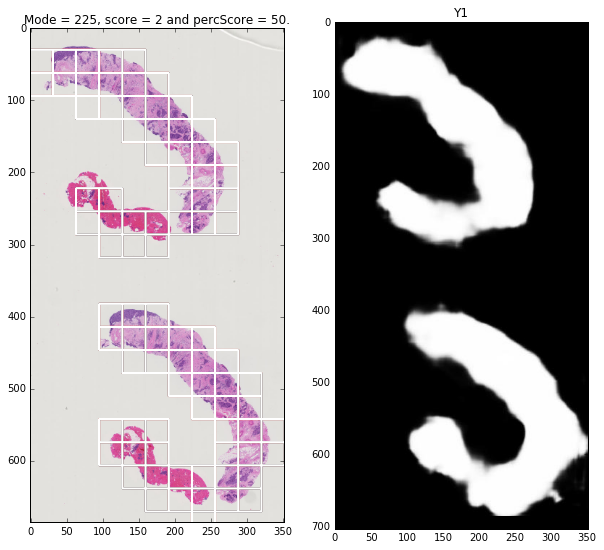

Number of regions generated at level 7 = 183 with dimension 128 x 128 x 3.
Image 27 with score of 3, percScore of 80. Region sizes generated 128.
/home/msmith/her2/data/roi_27/5/HER2/
/home/msmith/her2/data/roi_27/5/HE/


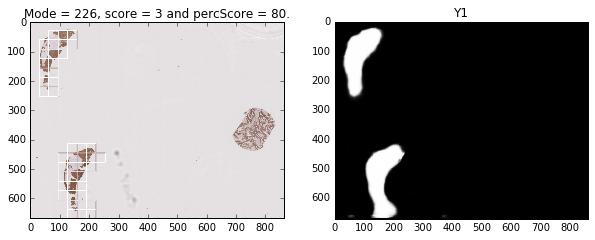

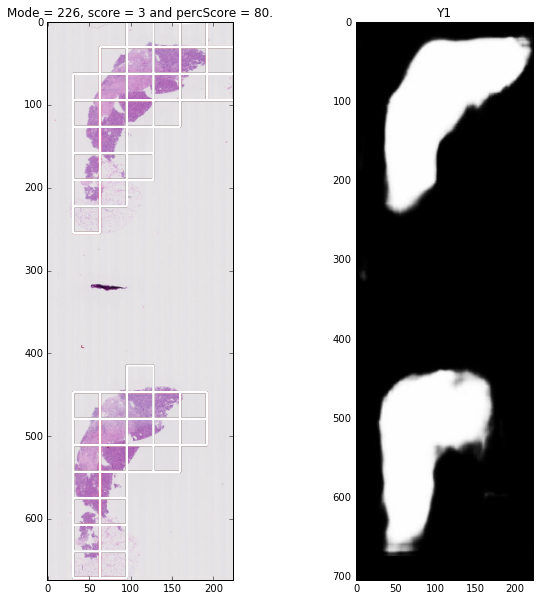

Number of regions generated at level 7 = 96 with dimension 128 x 128 x 3.
Image 29 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_29/5/HER2/
/home/msmith/her2/data/roi_29/5/HE/


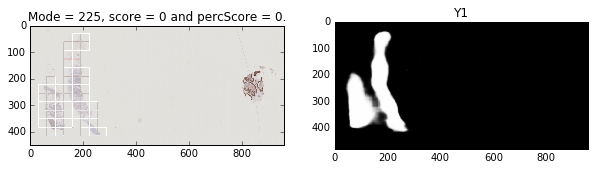

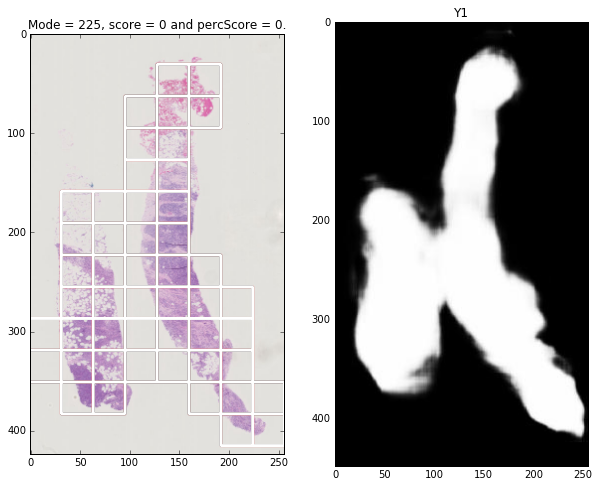

Number of regions generated at level 7 = 102 with dimension 128 x 128 x 3.
Image 30 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_30/5/HER2/
/home/msmith/her2/data/roi_30/5/HE/


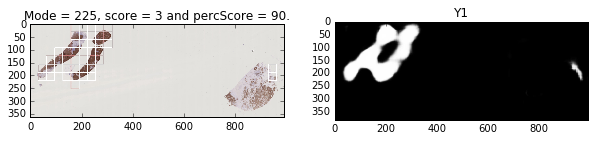

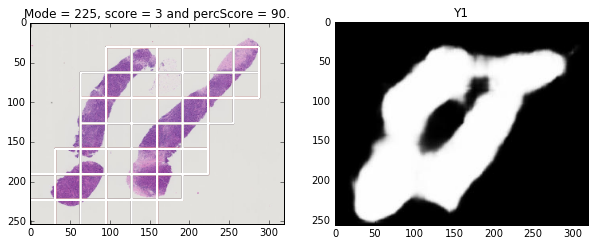

Number of regions generated at level 7 = 81 with dimension 128 x 128 x 3.
Image 32 with score of 1, percScore of 3. Region sizes generated 128.
/home/msmith/her2/data/roi_32/5/HER2/
/home/msmith/her2/data/roi_32/5/HE/


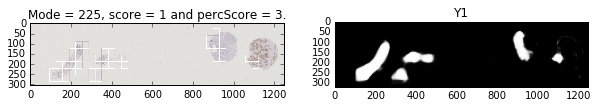

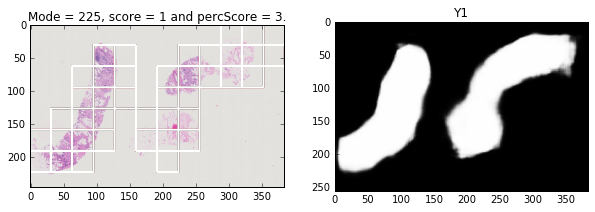

Number of regions generated at level 7 = 83 with dimension 128 x 128 x 3.
Image 33 with score of 3, percScore of 100. Region sizes generated 128.
/home/msmith/her2/data/roi_33/5/HER2/
/home/msmith/her2/data/roi_33/5/HE/


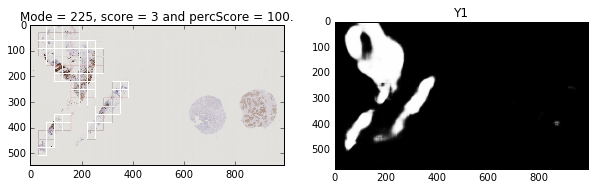

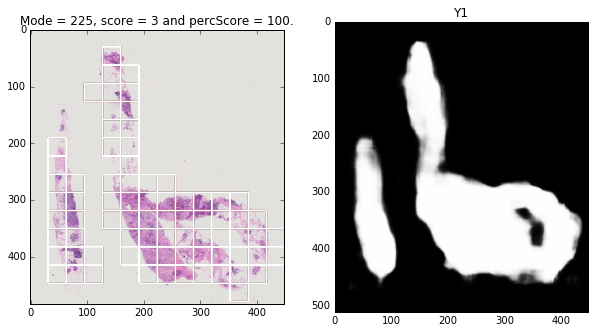

Number of regions generated at level 7 = 150 with dimension 128 x 128 x 3.
Image 34 with score of 1, percScore of 2. Region sizes generated 128.
/home/msmith/her2/data/roi_34/5/HER2/
/home/msmith/her2/data/roi_34/5/HE/


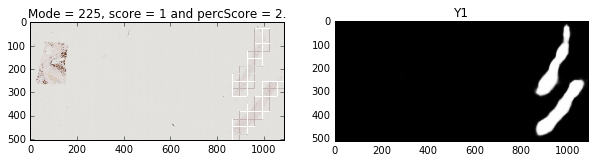

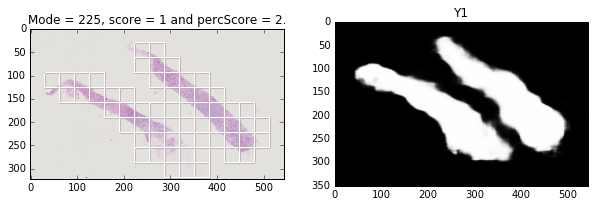

Number of regions generated at level 7 = 97 with dimension 128 x 128 x 3.
Image 35 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_35/5/HER2/
/home/msmith/her2/data/roi_35/5/HE/


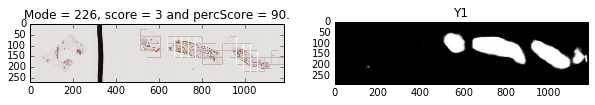

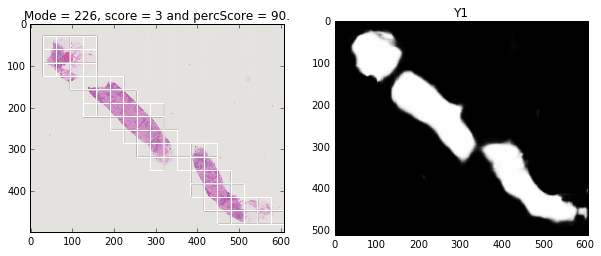

Number of regions generated at level 7 = 112 with dimension 128 x 128 x 3.
Image 36 with score of 2, percScore of 100. Region sizes generated 128.
/home/msmith/her2/data/roi_36/5/HER2/
/home/msmith/her2/data/roi_36/5/HE/


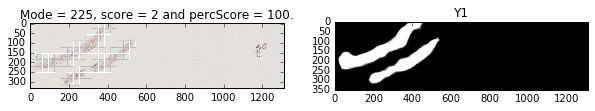

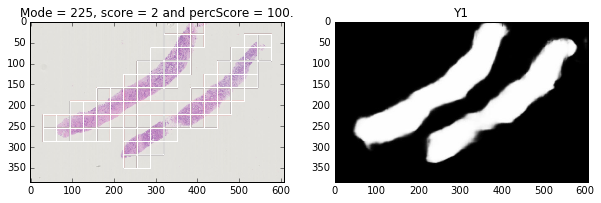

Number of regions generated at level 7 = 140 with dimension 128 x 128 x 3.
Image 38 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_38/5/HER2/
/home/msmith/her2/data/roi_38/5/HE/


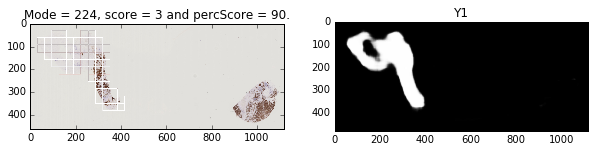

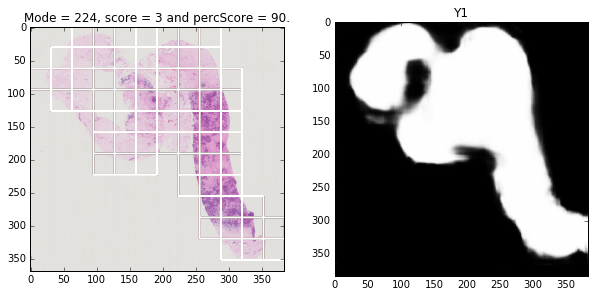

Number of regions generated at level 7 = 125 with dimension 128 x 128 x 3.
Image 39 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_39/5/HER2/
/home/msmith/her2/data/roi_39/5/HE/


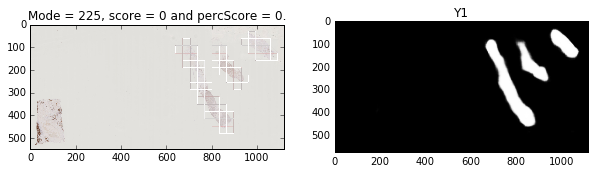

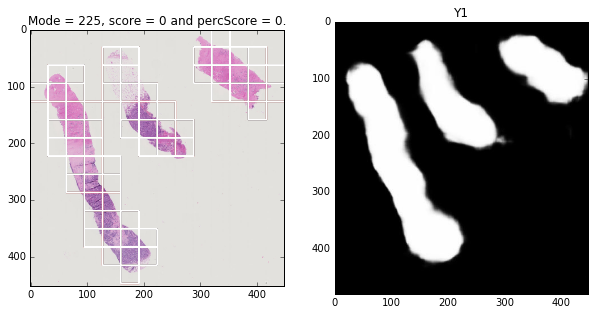

Number of regions generated at level 7 = 123 with dimension 128 x 128 x 3.
Image 40 with score of 2, percScore of 60. Region sizes generated 128.
/home/msmith/her2/data/roi_40/5/HER2/
/home/msmith/her2/data/roi_40/5/HE/


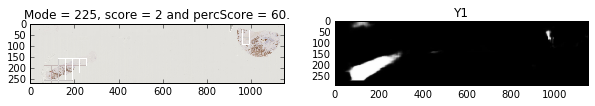

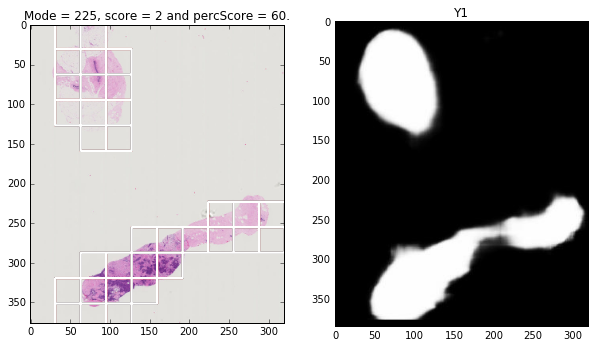

Number of regions generated at level 7 = 50 with dimension 128 x 128 x 3.
Image 46 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_46/5/HER2/
/home/msmith/her2/data/roi_46/5/HE/


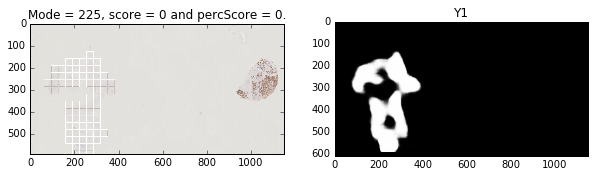

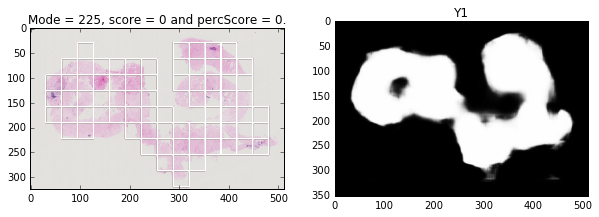

Number of regions generated at level 7 = 146 with dimension 128 x 128 x 3.
Image 47 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_47/5/HER2/
/home/msmith/her2/data/roi_47/5/HE/


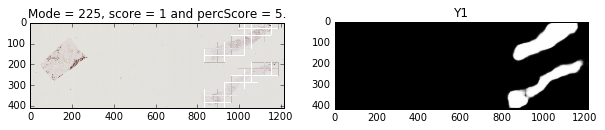

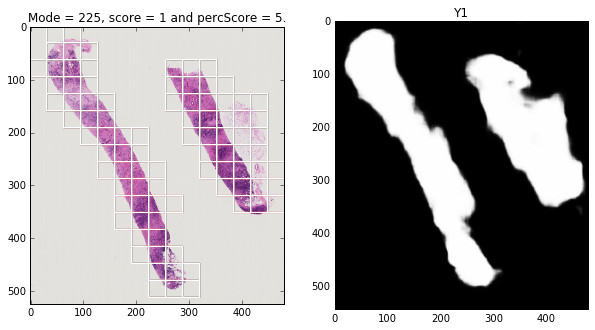

Number of regions generated at level 7 = 150 with dimension 128 x 128 x 3.
Image 48 with score of 2, percScore of 20. Region sizes generated 128.
/home/msmith/her2/data/roi_48/5/HER2/
/home/msmith/her2/data/roi_48/5/HE/


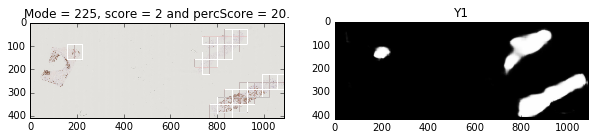

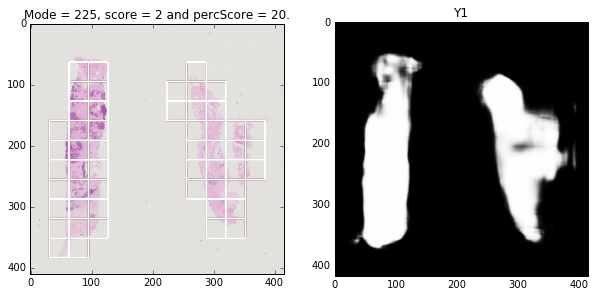

Number of regions generated at level 7 = 105 with dimension 128 x 128 x 3.
Image 49 with score of 2, percScore of 30. Region sizes generated 128.
/home/msmith/her2/data/roi_49/5/HER2/
/home/msmith/her2/data/roi_49/5/HE/


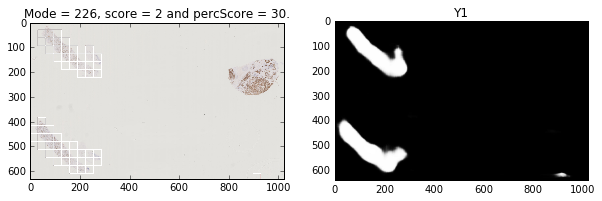

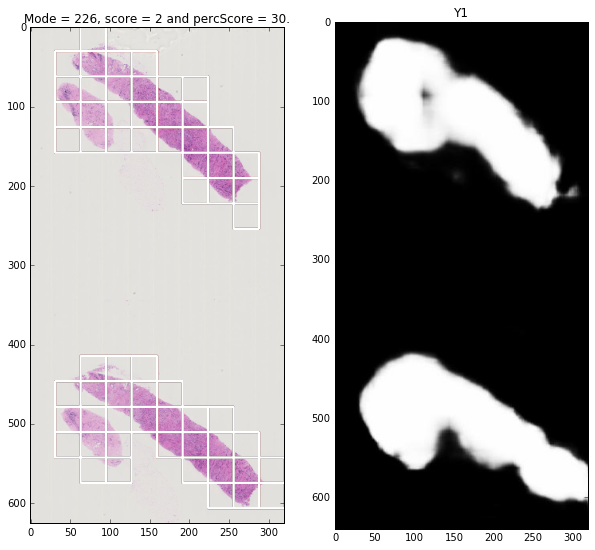

Number of regions generated at level 7 = 118 with dimension 128 x 128 x 3.
Image 50 with score of 2, percScore of 50. Region sizes generated 128.
/home/msmith/her2/data/roi_50/5/HER2/
/home/msmith/her2/data/roi_50/5/HE/


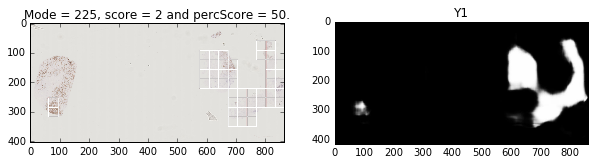

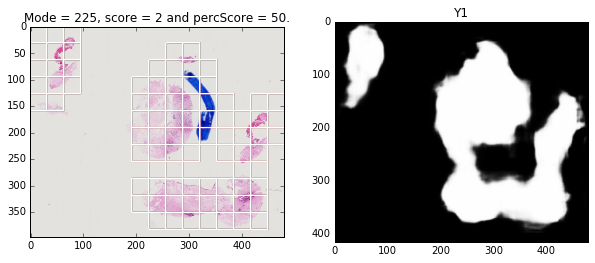

Number of regions generated at level 7 = 127 with dimension 128 x 128 x 3.
Image 52 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_52/5/HER2/
/home/msmith/her2/data/roi_52/5/HE/


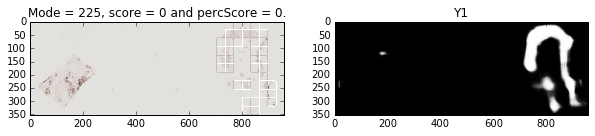

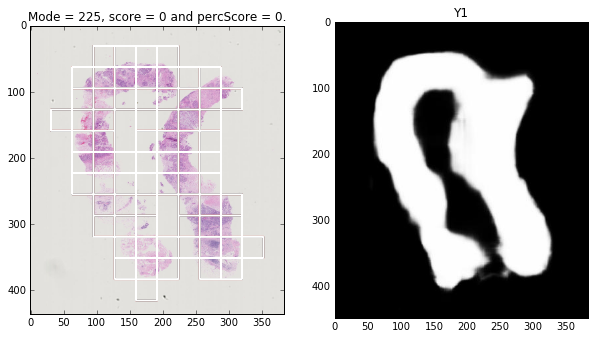

Number of regions generated at level 7 = 107 with dimension 128 x 128 x 3.
Image 55 with score of 2, percScore of 70. Region sizes generated 128.
/home/msmith/her2/data/roi_55/5/HER2/
/home/msmith/her2/data/roi_55/5/HE/


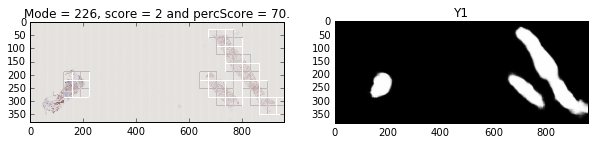

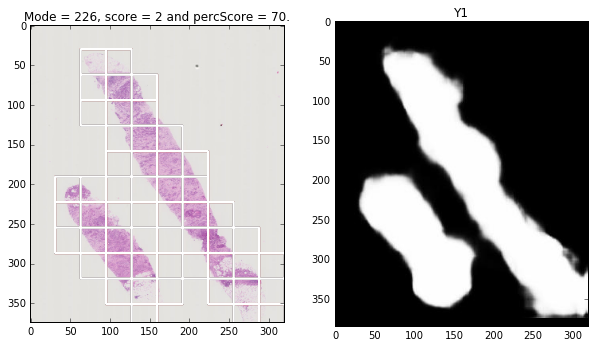

Number of regions generated at level 7 = 105 with dimension 128 x 128 x 3.
Image 57 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_57/5/HER2/
/home/msmith/her2/data/roi_57/5/HE/


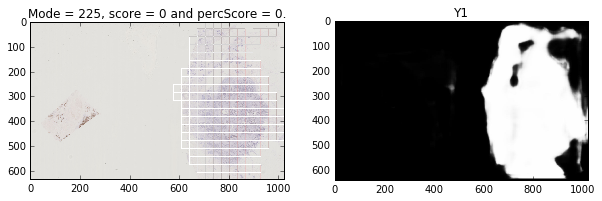

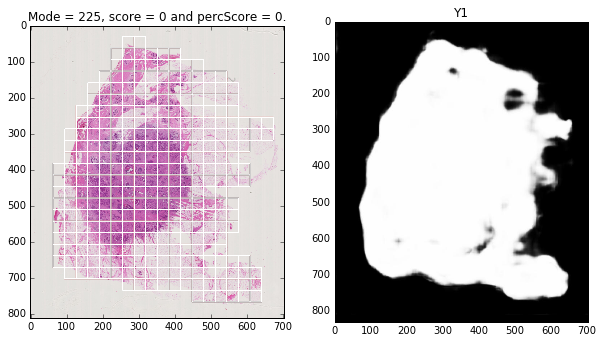

Number of regions generated at level 7 = 508 with dimension 128 x 128 x 3.
Image 58 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_58/5/HER2/
/home/msmith/her2/data/roi_58/5/HE/


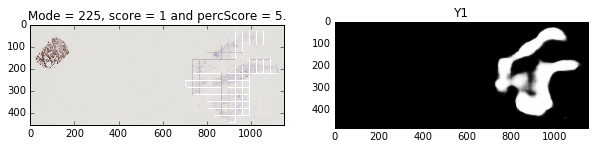

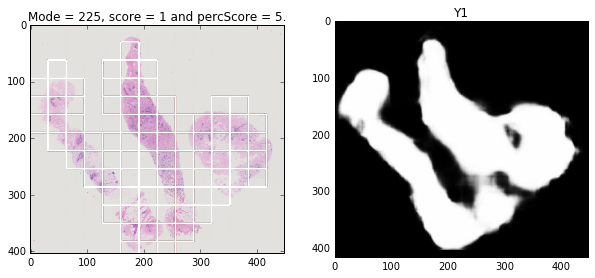

Number of regions generated at level 7 = 154 with dimension 128 x 128 x 3.
Image 61 with score of 3, percScore of 90. Region sizes generated 128.
/home/msmith/her2/data/roi_61/5/HER2/
/home/msmith/her2/data/roi_61/5/HE/


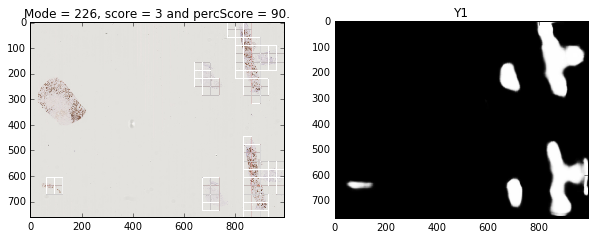

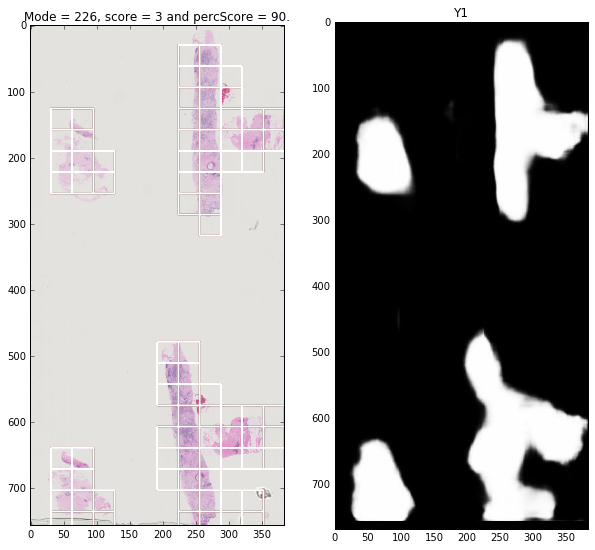

Number of regions generated at level 7 = 170 with dimension 128 x 128 x 3.
Image 63 with score of 2, percScore of 70. Region sizes generated 128.
/home/msmith/her2/data/roi_63/5/HER2/
/home/msmith/her2/data/roi_63/5/HE/


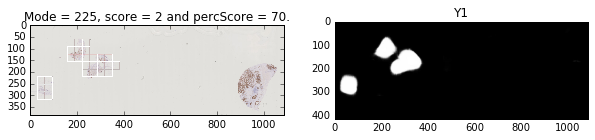

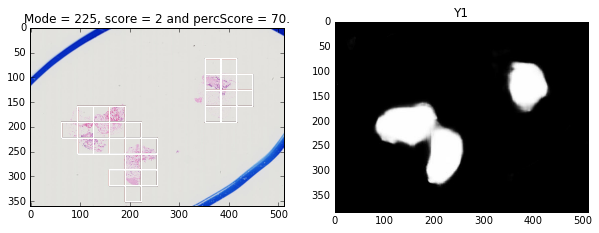

Number of regions generated at level 7 = 56 with dimension 128 x 128 x 3.
Image 65 with score of 1, percScore of 2. Region sizes generated 128.
/home/msmith/her2/data/roi_65/5/HER2/
/home/msmith/her2/data/roi_65/5/HE/


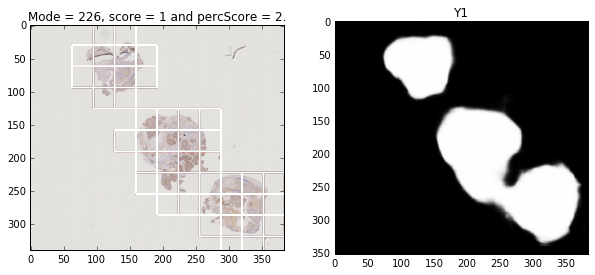

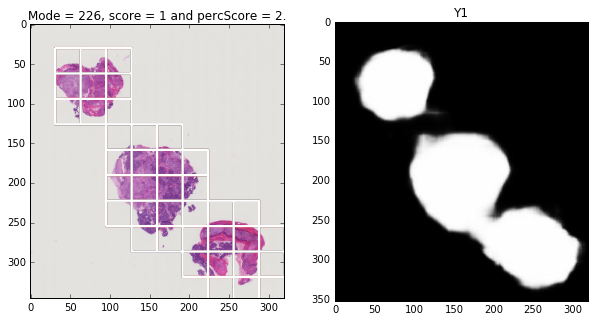

Number of regions generated at level 7 = 82 with dimension 128 x 128 x 3.
Image 66 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_66/5/HER2/
/home/msmith/her2/data/roi_66/5/HE/


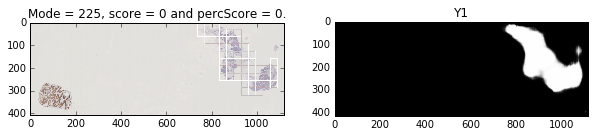

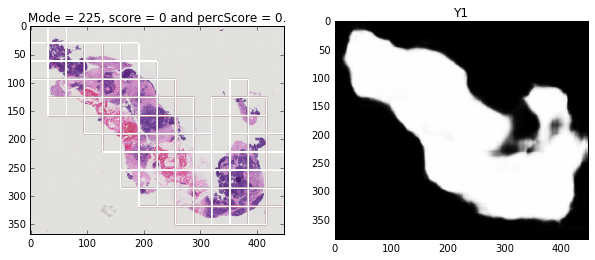

Number of regions generated at level 7 = 135 with dimension 128 x 128 x 3.
Image 67 with score of 2, percScore of 30. Region sizes generated 128.
/home/msmith/her2/data/roi_67/5/HER2/
/home/msmith/her2/data/roi_67/5/HE/


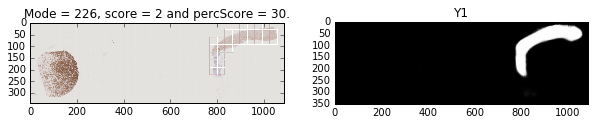

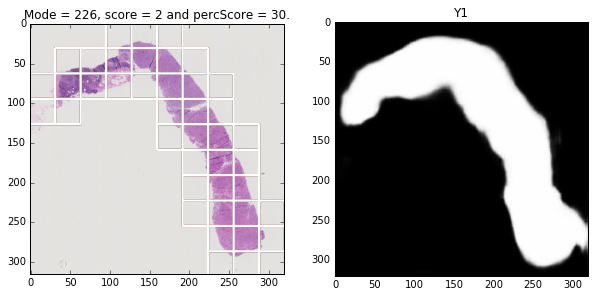

Number of regions generated at level 7 = 70 with dimension 128 x 128 x 3.
Image 68 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_68/5/HER2/
/home/msmith/her2/data/roi_68/5/HE/


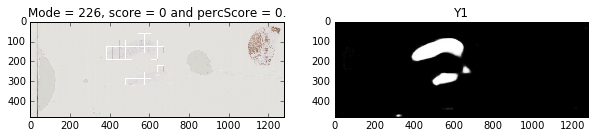

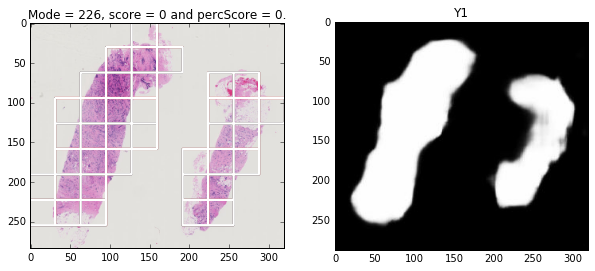

Number of regions generated at level 7 = 68 with dimension 128 x 128 x 3.
Image 70 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_70/5/HER2/
/home/msmith/her2/data/roi_70/5/HE/


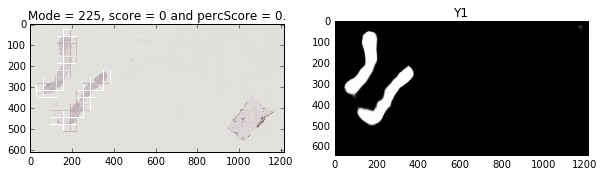

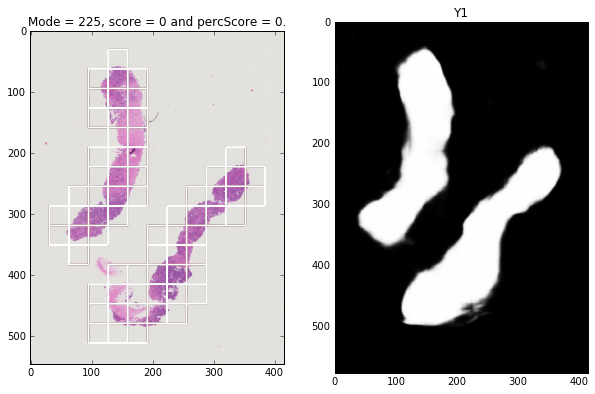

Number of regions generated at level 7 = 122 with dimension 128 x 128 x 3.
Image 73 with score of 0, percScore of 0. Region sizes generated 128.
/home/msmith/her2/data/roi_73/5/HER2/
/home/msmith/her2/data/roi_73/5/HE/


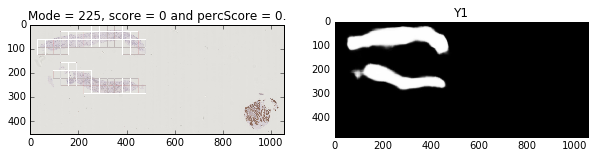

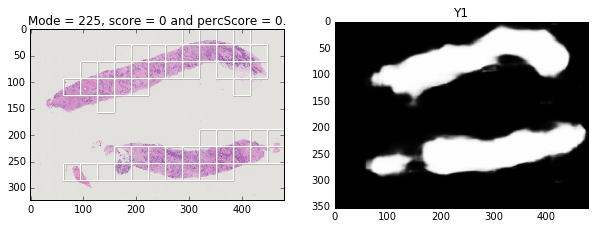

Number of regions generated at level 7 = 114 with dimension 128 x 128 x 3.
Image 74 with score of 2, percScore of 10. Region sizes generated 128.
/home/msmith/her2/data/roi_74/5/HER2/
/home/msmith/her2/data/roi_74/5/HE/


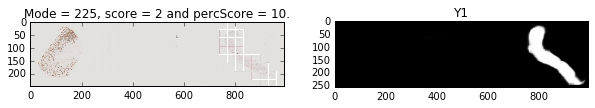

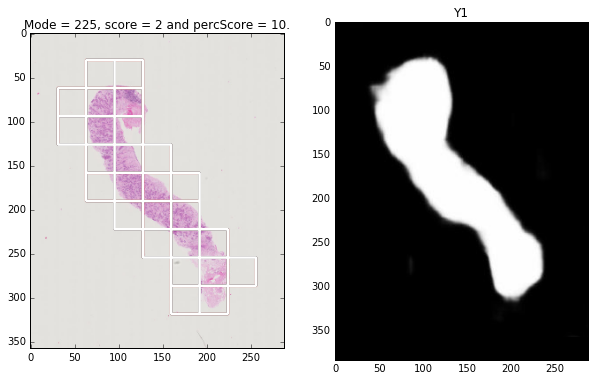

Number of regions generated at level 7 = 49 with dimension 128 x 128 x 3.
Image 79 with score of 1, percScore of 5. Region sizes generated 128.
/home/msmith/her2/data/roi_79/5/HER2/
/home/msmith/her2/data/roi_79/5/HE/


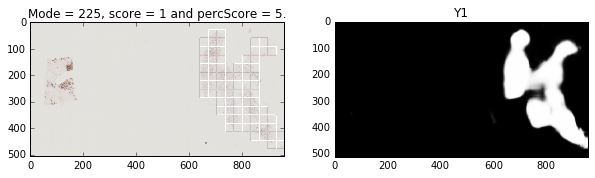

In [ ]:
if __name__ == "__main__":


    for upscaleLevel in upscaleLevels: # For each level
       
        upscaleWindowSize = np.power(2,12-upscaleLevel)
        print("==="*40)
        print("Upscale level %d" %upscaleLevel)
        print("==="*40)

        # Dimensions check
        dims = []

        # Generate ROIs and saave jpg
        for caseNo in groundTruth.CaseNo.values[:]:

            nRegions = 0
            eg = her2Image(caseNo,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize,train,method,saveThresh=0)
            print("==="*40)
            
            print("Image %d with score of %d, percScore of %d. Region sizes generated %d." % (caseNo,eg.score,eg.percScore,upscaleWindowSize))
            print("==="*40)
            
            
            for HE in [0,1]:
                newpath = writePath + "roi_" + str(caseNo) + "/" + str(upscaleLevel) + "/"
                if HE == 0:
                    he = "HER2"
                else:
                    he = "HE"
                newpath += str(he) + "/"
                
                print(newpath)
                if save == 1:
                    removeFiles(newpath)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
   
                
                regions = eg.regionGen(upscaleLevel,HE=HE) # region object
                regionNo = 0
                caseDims = [] 
                for region in regions:
                    nRegions += 1
                    if np.random.uniform() < displayProb and show == 1:
                        plt.imshow(region)
                        plt.show()
                         
                    
                    if save == 1:
                        imgPath = newpath + str(regionNo) + ".jpg"
                        region = region[:,:,:3] # remove alpha
                        region = region[:,:,::-1] # swap rgb
                        cv2.imwrite(imgPath,region)
                        
                    regionNo += 1
                    caseDims.append(region.shape)
                    #print("All alpha values == 255? %r" % np.all(region[:,:,3]==255))

            dims.append(caseDims)
            if upscaleLevel == 5:
                eg.showHER2()
                eg.showHE()
            numberOfRegions.append(nRegions)
            print("Number of regions generated at level %d = %d with dimension %d x %d x 3." % (eg.level,nRegions,caseDims[0][0],caseDims[0][1]))

    print("Smallest y: ", min([x[0][0] for x in dims]))
    print("Smallets x: ", min([x[0][1] for x in dims]))

    print("Biggest y: ", max([x[0][0] for x in dims]))
    print("Biggest x: ", max([x[0][1] for x in dims]))

    print("Number of regions generated: ",numberOfRegions)


# For filter model

In [ ]:
#Filter model params
def filterPaths ():
    writePath = "/home/msmith/her2/filter/data/"
    upscaleLevels = [5]
    threshArea = 0.25
    threshMargin = -40

def filterModelImages():
    filePaths = []
    for filePath in glob.glob("/home/msmith/her2/filter/data/*/*/*.jpg"):
        filePaths.append(filePath)
    pd.DataFrame(filePaths).to_csv("filterDataExtra.csv")

# For Deconvolutional

In [32]:
train = 0

if train == True:
    groundTruth = pd.read_csv("data/groundTruth.csv")
    writePath = "/home/msmith/her2/data/"
else:
    groundTruth = pd.read_csv("testData/groundTruth.csv")
    writePath = "/home/msmith/her2/testData/"


upscaleWindowSize = np.power(2,12-upscaleLevel)
for caseNo in groundTruth.CaseNo.values[:]:
    
    if train == 1:
        path = "data/"  
    else:
        path = "testData/"  
    
    writePath = "/home/msmith/her2/deconv/ " + path + "/roi_" + str(caseNo) + "/" + str(7) + "/"

    if not os.path.exists(writePath):
        os.makedirs(writePath)
    
    case = groundTruth.loc[groundTruth.CaseNo==caseNo]



    her2 = openslide.open_slide(path+str(caseNo)+'_HER2.ndpi') # Main image object in wdi format
    he = openslide.open_slide(path+str(caseNo)+'_HE.ndpi')
    nLevels = her2.level_count # Number of levels


    level = 7
    lowResDims,lowResDimsHE = [x.level_dimensions[level] for x in [her2,he]] #3 is arbitrary but works
    lowResRGB, lowResRGBHE = [np.asarray(x[0].read_region((0,0),
                level,(x[1][0],x[1][1]))).copy() for x in [(her2,lowResDims),
                                                                                      (he,lowResDimsHE)]] 
    cv2.imwrite(writePath + "HER2.jpg",lowResRGB)
    cv2.imwrite(writePath + "HE.jpg",lowResRGBHE)
    
